In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras

from datetime import date

%matplotlib inline

There are 2 data sets : 
1. bank.csv       : 461KB
2. bank-full.csv  : 4.6MB

The "bank-full.csv" has the full dataset and the "bank.csv" is a sample of that. First lest just play with the sample dataset, the at the end we will train our final model with the full data set.

In [3]:
df = pd.read_csv("data/bank+marketing/bank/bank.csv", sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


Lets analyze each column of the data set and their data types and is there any missing values.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


Looks like there are no missing values. \
Next lets get the column names of the catogorycal and non-catogorical features and analyze them individualy.

In [7]:
def cat_noncat_columns(df):
    catogorical = []
    non_catogorical = []
    
    for column in df:
        if df[column].dtype == "object":
            catogorical.append(column)
        else:
            non_catogorical.append(column)
    return catogorical, non_catogorical

In [8]:
catogorical, non_catogorical = cat_noncat_columns(df)

print(catogorical)
print(non_catogorical)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']
['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


Lets check unique values in catogorical columns.

In [10]:
for column in catogorical:
    print(f"{column} --> {df[column].unique()}")

job --> ['unemployed' 'services' 'management' 'blue-collar' 'self-employed'
 'technician' 'entrepreneur' 'admin.' 'student' 'housemaid' 'retired'
 'unknown']
marital --> ['married' 'single' 'divorced']
education --> ['primary' 'secondary' 'tertiary' 'unknown']
default --> ['no' 'yes']
housing --> ['no' 'yes']
loan --> ['no' 'yes']
contact --> ['cellular' 'unknown' 'telephone']
month --> ['oct' 'may' 'apr' 'jun' 'feb' 'aug' 'jan' 'jul' 'nov' 'sep' 'mar' 'dec']
poutcome --> ['unknown' 'failure' 'other' 'success']
y --> ['no' 'yes']


We can see there are some columns that has value "unknown".\
Lets check out those.

In [12]:
for column in catogorical:
    if "unknown" in df[column].unique():
        print(f"{column} --> {df[df[column] == "unknown"].shape[0]}")

job --> 38
education --> 187
contact --> 1324
poutcome --> 3705


Looks like there are so many "unknown" values in "contact" and "poutcome".\
Acording to the data source:
- poutcome	: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
- contact : contact communication type (categorical: 'cellular','telephone')

The outcome of the campaign for each user is always going to be hard to find out. So to rely on that feature would be irresponsible. Customer's preferd contact method also would be irrelelven for us. So I think it is ok to just drop these 2 columns. Later we can use "contact" data to recomend a marketing method.\
\
For other 2 columns we can just use "unknown" as acatogory.

Next lets create a function to drop those columns.

In [15]:
def drop_useless_columns(df, columns = ["contact", "poutcome"]):
    return df.drop(columns, axis=1)

In [16]:
df_column_droped = drop_useless_columns(df)
df_column_droped.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous',
       'y'],
      dtype='object')

Lets analyze the non catogorical columns.

In [18]:
df_column_droped[non_catogorical].describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


The "pdays" and the "previous" columns are looks bit suspisous.

Acording to the data source : 
- pday : number of days that passed by after the client was last contacted from a previous campaign (numeric; -1 means client was not previously contacted)
- previous : number of contacts performed before this campaign and for this client

So , these are ok.

# Lets visualize some data : 

Lets write a funcion to compare each non catogorical feature with the prediction class Y.\
This function will export a pdf of this report ro the exports folder.

In [22]:
def analysis_graphs_non_cat(df, non_categorical_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], show = False):
    
    plt.figure(figsize=(15, 25))
    
    for i, col in enumerate(non_categorical_columns):
        # --- Absolute counts ---
        plt.subplot(len(non_categorical_columns), 2, i*2 + 1)
        stayed = df[df.y == "yes"][col]
        exited = df[df.y == "no"][col]
        
        plt.hist([stayed, exited], color=['green', 'orange'], label=['Long term', "No long term"])
        plt.xlabel(col)
        plt.ylabel("Number of customers")
        plt.title(f"{col} vs Long term (Counts)")
        plt.legend()
    
        # --- Proportions ---
        plt.subplot(len(non_categorical_columns), 2, i*2 + 2)
        bins = np.linspace(df[col].min(), df[col].max(), 11)  # 10 bins
        counts_exited, _ = np.histogram(exited, bins=bins)
        counts_stayed, _ = np.histogram(stayed, bins=bins)
    
        total = counts_exited + counts_stayed
        total[total == 0] = 1  # avoid division by zero
    
        prop_exited = counts_exited / total
        prop_stayed = counts_stayed / total
    
        bin_centers = (bins[:-1] + bins[1:]) / 2
        width = (bins[1] - bins[0]) * 0.9
    
        plt.bar(bin_centers, prop_stayed, width=width, color="green", label="Long term")
        plt.bar(bin_centers, prop_exited, width=width, bottom=prop_stayed, color="orange", label="No long term")
        plt.xlabel(col)
        plt.ylabel("Proportion of customers")
        plt.title(f"{col} vs Long term (Proportional)")
        plt.legend()
    
    plt.tight_layout()
    plt.suptitle('"Having a long term deposit" Analysis for Categorical Features (Non-Catogorical)', fontsize=20, y=1.02)
    plt.savefig("exports/analysis_non_catogorical.pdf", bbox_inches="tight")
    print("analysis_non_catogorical.pdf exported")
    if show == True : plt.show()

analysis_non_catogorical.pdf exported


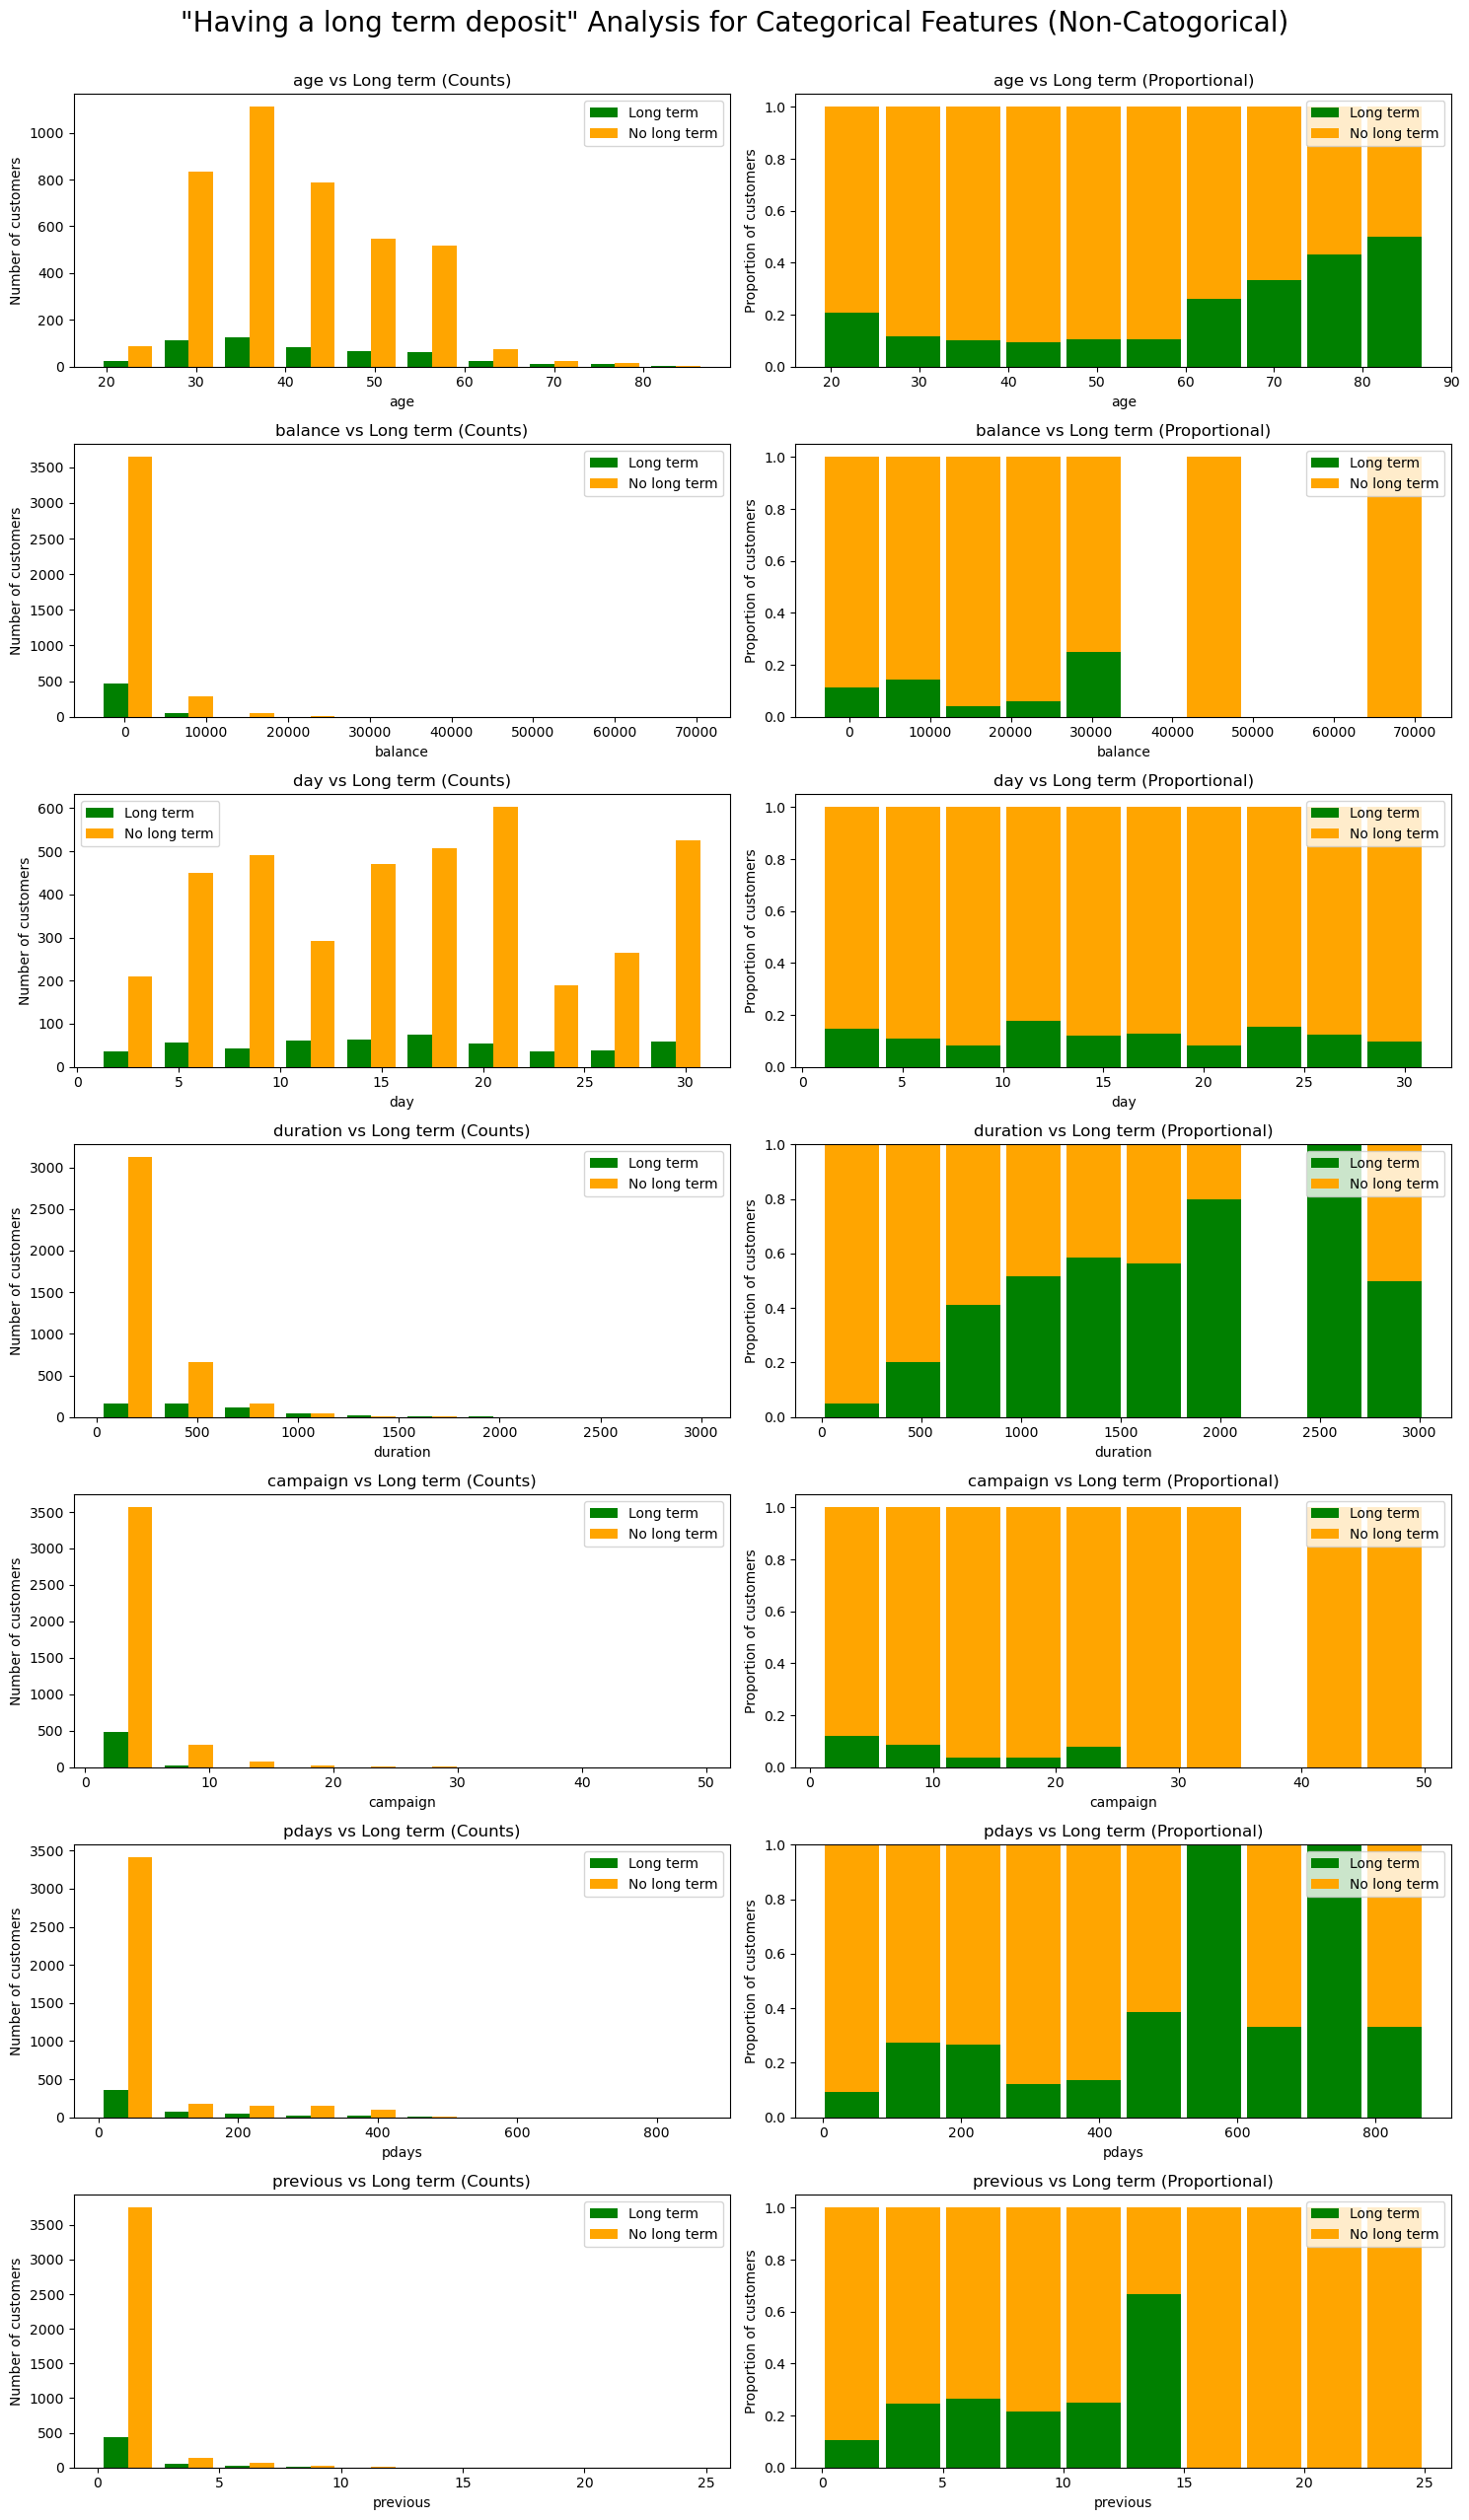

In [23]:
analysis_graphs_non_cat(df_column_droped, show=True)

By taking a peek at this report we can see propotionaly more older people has long term deposits.\
Also we can see that the duration of last contact directly propotinal to haven a long term deposit. That could be because when setting a long term deposit people have to contact with the bank for a long time.

Lets write a funcion to compare each catogorical feature with the prediction class Y.\
This function will export a pdf of this report ro the exports folder.

In [26]:
def analysis_graphs_cat(df, categorical_columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'month'], show=False):
    import matplotlib.pyplot as plt
    import os
    os.makedirs("exports", exist_ok=True)
    
    if categorical_columns is None:
        categorical_columns = ['job', 'marital', 'education', 'default', 
                               'housing', 'loan', 'contact', 'month', 'poutcome']
    
    plt.figure(figsize=(12, len(categorical_columns)*3))
    
    for i, col in enumerate(categorical_columns):
        # --- Absolute counts ---
        plt.subplot(len(categorical_columns), 2, i*2 + 1)
        stayed = df[df["y"] == "yes"][col]
        exited = df[df["y"] == "no"][col]
        plt.hist([stayed, exited], color=['green', 'orange'], label=['Long term', "No long term"])
        plt.xticks(rotation=45, ha='right')
        plt.xlabel(col)
        plt.ylabel("Number of customers")
        plt.title(f"{col} vs Long term (Counts)")
        plt.legend()
    
        # --- Proportions ---
        plt.subplot(len(categorical_columns), 2, i*2 + 2)
        geo_counts = df.groupby([col, "y"]).size().unstack(fill_value=0)
        
        stayed = geo_counts["yes"]
        exited = geo_counts["no"]
        total = stayed + exited
        total[total == 0] = 1
        
        stayed_prop = stayed / total
        exited_prop = exited / total
        
        x = range(len(geo_counts.index))
        plt.bar(x, stayed_prop, color="green", label="Long term")
        plt.bar(x, exited_prop, bottom=stayed_prop, color="orange", label="No long term")
        plt.xticks(x, geo_counts.index, rotation=45)
        plt.xlabel(col)
        plt.ylabel("Proportion of customers")
        plt.title(f"{col} vs Long term (Proportional)")
        plt.legend()
    
    plt.suptitle('"Having a long term deposit" Analysis for Categorical Features (Categorical)', fontsize=18, y=1.02)
    plt.tight_layout()
    plt.savefig("exports/analysis_categorical.pdf", bbox_inches="tight")
    print("analysis_categorical.pdf exported")
    if show:
        plt.show()

analysis_categorical.pdf exported


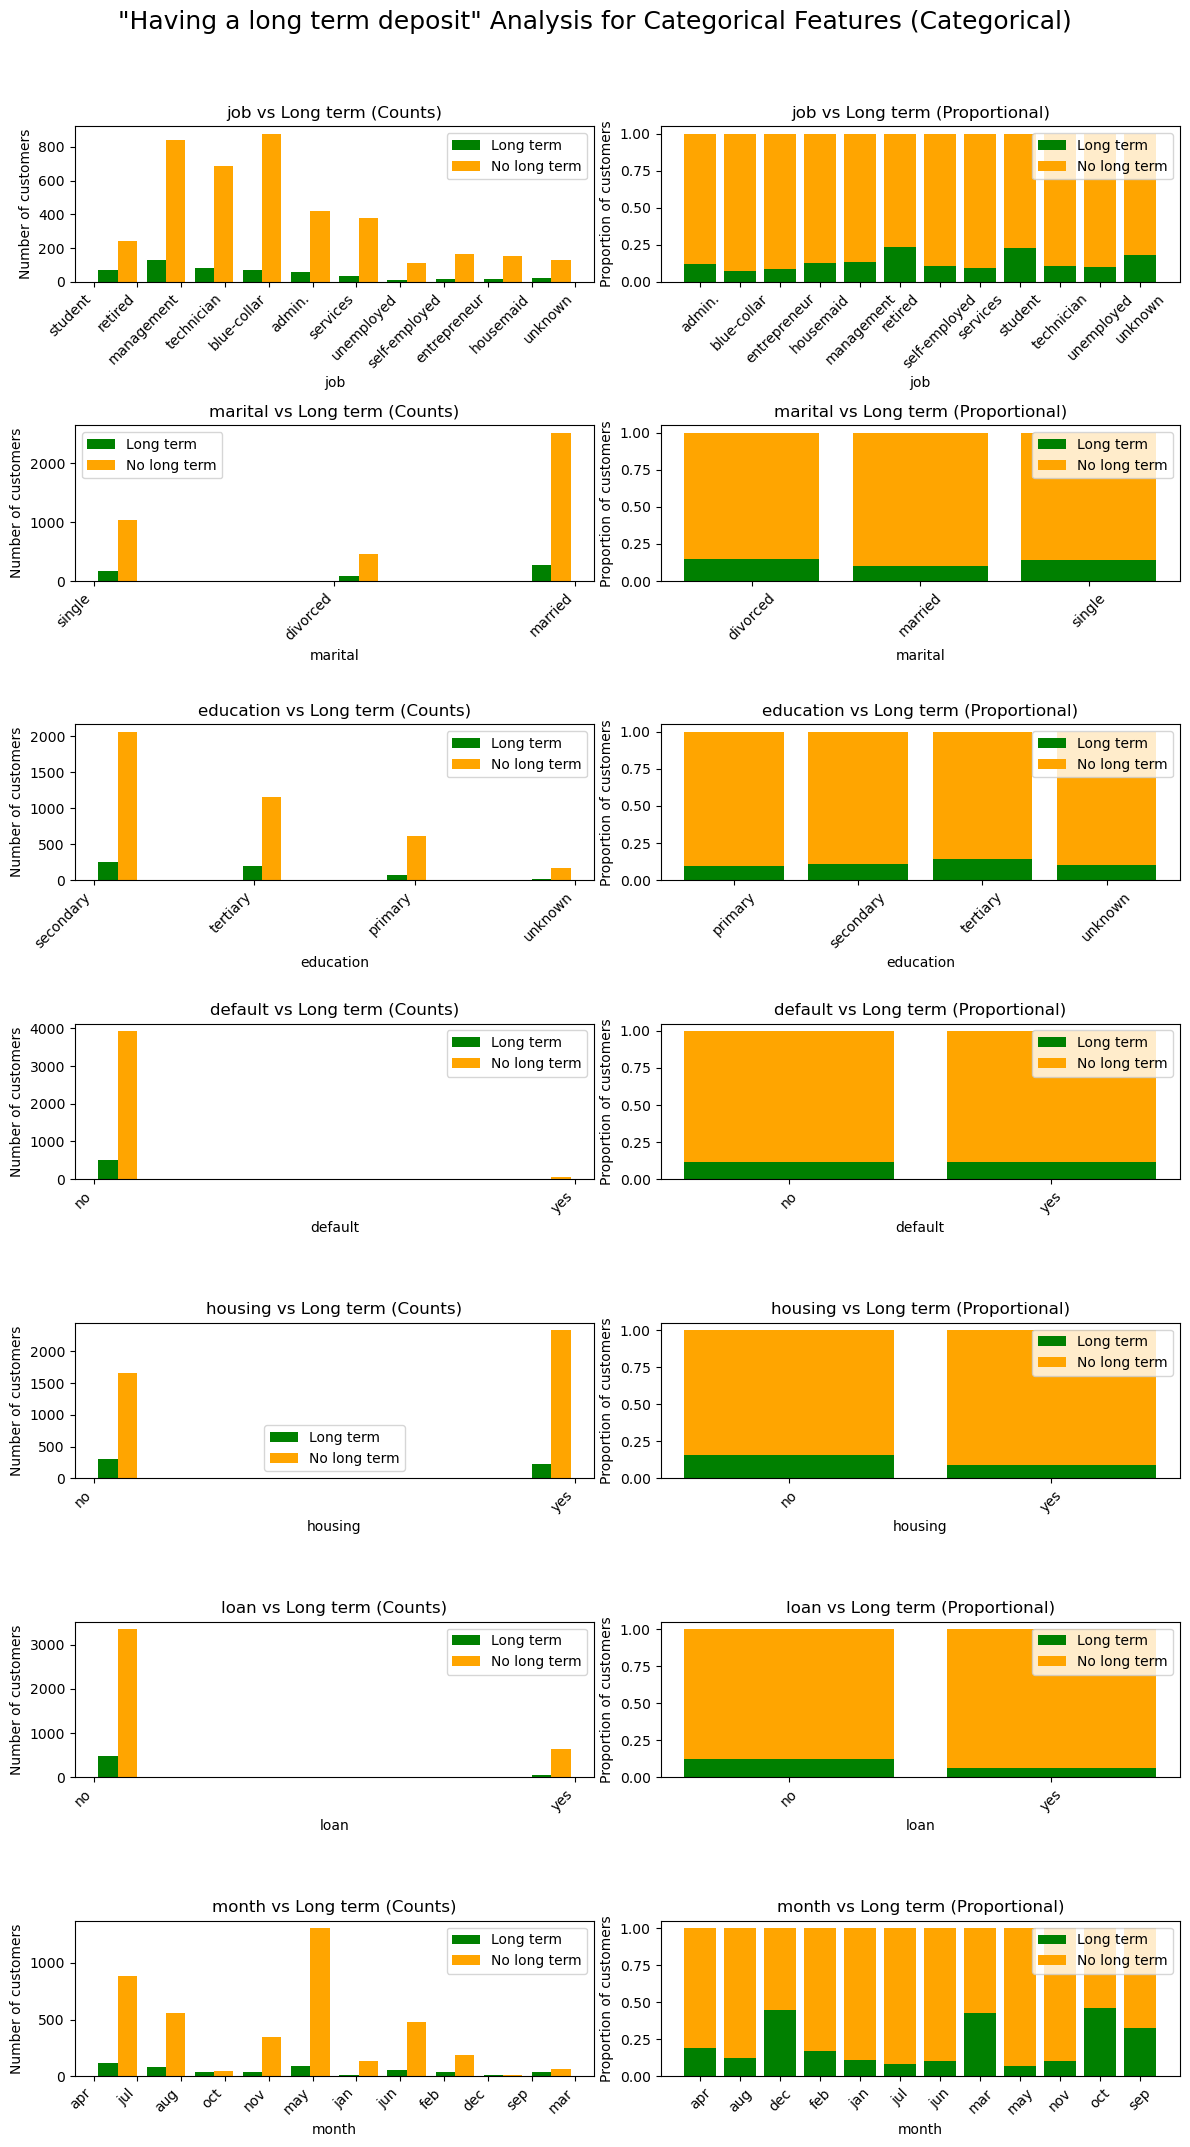

In [27]:
analysis_graphs_cat(df_column_droped, show=True)

There are no obvoius trends we can see. But there are some usefull information like distribution of users for each type of job ect.

Ok, lets create a function to convert those catogorical columns into numerical values.

In [30]:
def convert_dummy_features(df, columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'y']):
    return pd.get_dummies(data=df, columns=columns, dtype=int).drop(["y_no"], axis=1)

In [31]:
df_all_numerical = convert_dummy_features(df_column_droped)
df_all_numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 45 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  4521 non-null   int64
 1   balance              4521 non-null   int64
 2   day                  4521 non-null   int64
 3   duration             4521 non-null   int64
 4   campaign             4521 non-null   int64
 5   pdays                4521 non-null   int64
 6   previous             4521 non-null   int64
 7   job_admin.           4521 non-null   int64
 8   job_blue-collar      4521 non-null   int64
 9   job_entrepreneur     4521 non-null   int64
 10  job_housemaid        4521 non-null   int64
 11  job_management       4521 non-null   int64
 12  job_retired          4521 non-null   int64
 13  job_self-employed    4521 non-null   int64
 14  job_services         4521 non-null   int64
 15  job_student          4521 non-null   int64
 16  job_technician       452

We can see now all columns are numerical and there are no object type columns.

Next, lets create a function to scale all of these values to increase the training time.

In [34]:
def scaller_train(df, non_categorical_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']):
    scaller = MinMaxScaler()
    scaller.fit(df[non_categorical_columns])
    joblib.dump(scaller, 'exports/minmax_scaler.joblib')

def scaller_scale(df, non_categorical_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']):
    loaded_scaler = joblib.load('exports/minmax_scaler.joblib')
    df[non_categorical_columns] = loaded_scaler.transform(df[non_categorical_columns])
    return df

Here we have 2 functions,
1. scaller_train : To train teh scaller. This will export the transformer model.
2. scaller_scale : To scale the values, This will load that model and conver the values.

In [36]:
scaller_train(df = df_all_numerical)
df_scalled = scaller_scale(df = df_all_numerical)
df_scalled.describe()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,y_yes
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,...,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,0.326031,0.063565,0.497176,0.086051,0.036605,0.046751,0.021703,0.105729,0.209246,0.037160,...,0.049104,0.032736,0.156160,0.117452,0.010838,0.309224,0.086043,0.017695,0.011502,0.115240
std,0.155533,0.040397,0.274922,0.086017,0.063465,0.114818,0.067742,0.307524,0.406815,0.189174,...,0.216109,0.177965,0.363047,0.321994,0.103553,0.462225,0.280458,0.131856,0.106640,0.319347
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.205882,0.045395,0.266667,0.033102,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.294118,0.050429,0.500000,0.059914,0.020408,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.441176,0.064335,0.666667,0.107580,0.040816,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We can see all the data now are scaled (min and max are between 0 and 1).

Lets check the ratio of long term vs no long term

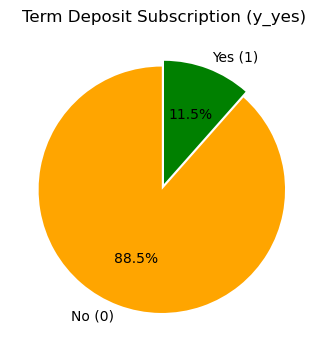

In [39]:
counts = df_scalled['y_yes'].value_counts()

plt.figure(figsize=(4,4))
plt.pie(
    counts,
    labels=['No (0)', 'Yes (1)'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['orange', 'green'],
    explode=(0.05, 0)
)
plt.title('Term Deposit Subscription (y_yes)')
plt.show()

We can see there is a huge propotinal diference between these classes.\
So we are going to augment new data using SMOTE method.

In [41]:
len(df_scalled.columns)

45

In [42]:
def augment_data(df):
    smote = SMOTE(sampling_strategy='minority')
    X_sm, y_sm = smote.fit_resample(df.drop(['y_yes'], axis=1), df["y_yes"])
    df_augmented = pd.concat([pd.DataFrame(X_sm, columns=df.columns[:-1]),
                              pd.Series(y_sm, name='y_yes')], axis=1)
    return df_augmented

In [43]:
df_augmented = augment_data(df_scalled)
print(f"Before SMOTE: {df_scalled.shape}, After SMOTE: {df_augmented.shape}")

Before SMOTE: (4521, 45), After SMOTE: (8000, 45)


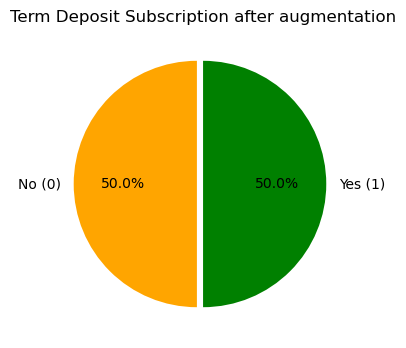

In [44]:
counts = df_augmented['y_yes'].value_counts()

plt.figure(figsize=(4,4))
plt.pie(
    counts,
    labels=['No (0)', 'Yes (1)'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['orange', 'green'],
    explode=(0.05, 0)
)
plt.title('Term Deposit Subscription after augmentation')
plt.show()

Now both classes are balanced.

Lets create a function to split the data into train and test sets.

In [47]:
df2 = pd.read_csv("data/bank+marketing/bank/bank-full.csv", sep=';')
df2.shape

(45211, 17)

In [48]:
def split_dataset(df, target="y_yes", ratio=0.1):
    y = df[target]  # target column
    train, test = train_test_split(
        df,
        test_size=ratio,
        random_state=42,
        shuffle=True,
        stratify=y
    )
    return train, test

In [49]:
df_train, df_test = split_dataset(df_augmented)
print(df_train.shape)
print(df_test.shape)

(7200, 45)
(800, 45)


Now data set is devided to train and test sets.\
If you think the test size is small, when we use the full data set, we will have a much larger test data set.

Next lets create a function to train a model.

In [52]:
def train_model(df_train, epochs = 50):
    model = keras.Sequential([
        keras.layers.Input(shape=(44,)),
        keras.layers.Dense(44, activation="relu"),
        keras.layers.Dense(20, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dense(1, activation="sigmoid")
    ])
    
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    x = df_train.drop(['y_yes'], axis=1)
    y = df_train['y_yes']
    model.fit(x, y, validation_split=0.2, epochs=epochs)

    return model

In [53]:
model = train_model(df_train, epochs=100)

Epoch 1/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step - accuracy: 0.6246 - loss: 0.6778 - val_accuracy: 0.7715 - val_loss: 0.5307
Epoch 2/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - accuracy: 0.8054 - loss: 0.4821 - val_accuracy: 0.8583 - val_loss: 0.3640
Epoch 3/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - accuracy: 0.8775 - loss: 0.3508 - val_accuracy: 0.8826 - val_loss: 0.3079
Epoch 4/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - accuracy: 0.8953 - loss: 0.2897 - val_accuracy: 0.8792 - val_loss: 0.2942
Epoch 5/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - accuracy: 0.9001 - loss: 0.2736 - val_accuracy: 0.9035 - val_loss: 0.2868
Epoch 6/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - accuracy: 0.9061 - loss: 0.2634 - val_accuracy: 0.8743 - val_loss: 0.2987
Epoch 7/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - accuracy: 0.9089 - loss: 0.2547 - val_accuracy: 0.8861 - val_loss: 0.3084
Epoch 8/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - accuracy: 0.9091 - loss: 0

Looks like our model has a good training acuracy.\
Lets try to create another model to compare with this.

In [55]:
def train_model2(df_train, epochs = 50):
    model = keras.Sequential([
        keras.layers.Input(shape=(44,)),
    
        keras.layers.Dense(64, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
    
        keras.layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
    
        keras.layers.Dense(1, activation="sigmoid")
    ])
    
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    x = df_train.drop(['y_yes'], axis=1)
    y = df_train['y_yes']
    model.fit(x, y, validation_split=0.2, epochs=epochs, batch_size=32)

    return model

In [56]:
model2 = train_model2(df_train, epochs=100)

Epoch 1/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5804 - loss: 0.8163 - val_accuracy: 0.6986 - val_loss: 0.6397
Epoch 2/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 0.7244 - loss: 0.5903 - val_accuracy: 0.8618 - val_loss: 0.4561
Epoch 3/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - accuracy: 0.8114 - loss: 0.4484 - val_accuracy: 0.9000 - val_loss: 0.3167
Epoch 4/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - accuracy: 0.8605 - loss: 0.3752 - val_accuracy: 0.8979 - val_loss: 0.2978
Epoch 5/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - accuracy: 0.8781 - loss: 0.3280 - val_accuracy: 0.8986 - val_loss: 0.2935
Epoch 6/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - accuracy: 0.8920 - loss: 0.3038 - val_accuracy: 0.9062 - val_loss: 0.2638
Epoch 7/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - accuracy: 0.8919 - loss: 0.3033 - val_accuracy: 0.8986 - val_loss: 0.2605
Epoch 8/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - accuracy: 0.8958 - loss: 0.2

In [57]:
def train_model3(df_train, epochs=50):
    x = df_train.drop(['y_yes'], axis=1).to_numpy()
    y = df_train['y_yes'].astype(int).to_numpy()

    model = keras.Sequential([
        keras.layers.Input(shape=(x.shape[1],)),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),

        keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),

        keras.layers.Dense(32, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.1),

        keras.layers.Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.BinaryAccuracy(name="accuracy"),
            keras.metrics.AUC(name="auc"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall")
        ]
    )

    classes = np.unique(y)
    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=y
    )
    class_weights = dict(zip(classes, weights))
    print("Class Weights:", class_weights)

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_auc', patience=10, restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_auc', factor=0.5, patience=5, verbose=1
        )
    ]

    model.fit(
        x, y,
        validation_split=0.2,
        epochs=epochs,
        batch_size=32,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )

    return model

In [58]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7200 entries, 5617 to 7470
Data columns (total 45 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  7200 non-null   float64
 1   balance              7200 non-null   float64
 2   day                  7200 non-null   float64
 3   duration             7200 non-null   float64
 4   campaign             7200 non-null   float64
 5   pdays                7200 non-null   float64
 6   previous             7200 non-null   float64
 7   job_admin.           7200 non-null   int64  
 8   job_blue-collar      7200 non-null   int64  
 9   job_entrepreneur     7200 non-null   int64  
 10  job_housemaid        7200 non-null   int64  
 11  job_management       7200 non-null   int64  
 12  job_retired          7200 non-null   int64  
 13  job_self-employed    7200 non-null   int64  
 14  job_services         7200 non-null   int64  
 15  job_student          7200 non-null   int

In [59]:
model3 = train_model3(df_train, epochs=100)

Class Weights: {0: 1.0, 1: 1.0}
Epoch 1/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6221 - auc: 0.6616 - loss: 0.8116 - precision: 0.6247 - recall: 0.6100 - val_accuracy: 0.7757 - val_auc: 0.9015 - val_loss: 0.6050 - val_precision: 0.7100 - val_recall: 0.9148 - learning_rate: 0.0010
Epoch 2/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8131 - auc: 0.8961 - loss: 0.4883 - precision: 0.8229 - recall: 0.8054 - val_accuracy: 0.8958 - val_auc: 0.9557 - val_loss: 0.3647 - val_precision: 0.9074 - val_recall: 0.8764 - learning_rate: 0.0010
Epoch 3/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - accuracy: 0.8661 - auc: 0.9358 - loss: 0.4009 - precision: 0.8677 - recall: 0.8595 - val_accuracy: 0.9139 - val_auc: 0.9638 - val_loss: 0.3144 - val_precision: 0.9215 - val_recall: 0.9006 - learning_rate: 0.0010
Epoch 4/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.8995 - auc: 0.9591 - loss: 0.3311 - precision: 0.9008 - recall: 0.8983 - val_accuracy: 0.9062 - 

Model 1's training acuracy is better than model 2.\
Lets create a function to evaluate these models.

In [115]:
def model_evaluate_export(df_test, model, name, export=True):
    x = df_test.drop(['y_yes'], axis=1)
    y = df_test['y_yes']
    yhat = model.predict(x)
    yhat_classes = (yhat > 0.5).astype("int32")
    if export : model.save(f"{name}_{date.today().strftime('%Y-%m-%d')}.keras")
    print(classification_report(y, yhat_classes))

In [62]:
model_evaluate_export(df_test, model, "model1")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       400
           1       0.91      0.91      0.91       400

    accuracy                           0.91       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.91      0.91      0.91       800



In [63]:
model_evaluate_export(df_test, model2, "model2")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       400
           1       0.92      0.92      0.92       400

    accuracy                           0.92       800
   macro avg       0.92      0.92      0.92       800
weighted avg       0.92      0.92      0.92       800



In [64]:
model_evaluate_export(df_test, model3, "model3")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       400
           1       0.92      0.92      0.92       400

    accuracy                           0.92       800
   macro avg       0.92      0.92      0.92       800
weighted avg       0.92      0.92      0.92       800



By analyzing these 2 evaluations we can see model 1 is beter than model 2 because it is balanced, eventhough both has same testing acuracy.

Next create a preprocessing function to apply all above transformations easily.\
This function will aply all the preprocessings to the given ata set acording to weather it the test or train set.

In [67]:
def preprocessing(df, is_train):
    df_droped = drop_useless_columns(df, columns = ["contact", "poutcome"])
    df_numeric = convert_dummy_features(df_droped, columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'y'])
    if is_train : scaller_train(df_numeric, non_categorical_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'])
    df_scalled = scaller_scale(df_numeric, non_categorical_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'])
    if is_train:
        df_augmented = augment_data(df_scalled)
        return df_augmented
    else:
        return df_scalled
    

Lets create a function to devide a given data set into train, dev and test sets (.8, .1, .1)

In [69]:
def train_dev_test(df, target="y_yes" ):
    df_train, df_test = split_dataset(df, target=target, ratio=0.1)
    df_dev, df_test = split_dataset(df, target=target, ratio=0.5)
    
    return df_train, df_dev, df_test

Lets load up our full data set.

Lets create a function to apply all the preprocessings to the full data set and train the model using that.

In [76]:
df_full = pd.read_csv("data/bank+marketing/bank/bank-full.csv", sep=';')
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [94]:
def full_process(df):
    df_train, df_dev, df_test = train_dev_test(df, target="y")
    
    df_train_processed = preprocessing(df_train, is_train=True)
    df_dev_processed = preprocessing(df_dev, is_train=False)
    df_test_processed = preprocessing(df_test, is_train=False)

    model1 = train_model(df_train_processed, epochs=100)
    model2 = train_model2(df_train_processed, epochs=100)
    model3 = train_model3(df_train_processed, epochs=100)

    model_evaluate_export(df_dev_processed, model1, "full_model_1")
    model_evaluate_export(df_dev_processed, model2, "full_model_2")
    model_evaluate_export(df_dev_processed, model3, "full_model_3")

    return df_test_processed

In [96]:
df_test = full_process(df_full)

Epoch 1/100
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 1s 576us/step - accuracy: 0.7269 - loss: 0.5433 - val_accuracy: 0.8383 - val_loss: 0.4038
Epoch 2/100
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 1s 549us/step - accuracy: 0.8543 - loss: 0.3529 - val_accuracy: 0.8706 - val_loss: 0.3644
Epoch 3/100
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 1s 558us/step - accuracy: 0.8685 - loss: 0.3241 - val_accuracy: 0.8835 - val_loss: 0.3398
Epoch 4/100
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 1s 558us/step - accuracy: 0.8747 - loss: 0.3094 - val_accuracy: 0.8649 - val_loss: 0.3854
Epoch 5/100
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 1s 511us/step - accuracy: 0.8768 - loss: 0.3009 - val_accuracy: 0.8584 - val_loss: 0.3758
Epoch 6/100
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 1s 510us/step - accuracy: 0.8779 - loss: 0.2948 - val_accuracy: 0.9117 - val_loss: 0.2811
Epoch 7/100
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - accuracy: 0.8823 - loss: 0.2848 - val_accuracy: 0.9072 - val_loss: 0.2992
Epoch 8/100
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 1s 513us/step - accuracy: 

I think model 1 is the best out of 3.\
Lets load up that and create the confusion matrix

In [110]:
df_test

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,y_yes
33163,0.155844,0.116990,0.633333,0.001627,0.080645,0.352064,0.010909,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15176,0.194805,0.073657,0.533333,0.012607,0.000000,0.000000,0.000000,0,0,0,...,0,0,1,0,0,0,0,0,0,0
38911,0.116883,0.073076,0.566667,0.022367,0.000000,0.384174,0.014545,0,1,0,...,0,0,0,0,0,1,0,0,0,0
32963,0.142857,0.074882,0.533333,0.055510,0.016129,0.394495,0.003636,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21812,0.376623,0.072903,0.633333,0.032940,0.016129,0.000000,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14259,0.233766,0.072803,0.433333,0.016267,0.016129,0.000000,0.000000,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4366,0.350649,0.085014,0.600000,0.024400,0.096774,0.000000,0.000000,0,1,0,...,0,0,0,0,0,1,0,0,0,0
22024,0.532468,0.096118,0.633333,0.012810,0.064516,0.000000,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44138,0.506494,0.082282,0.366667,0.115291,0.000000,0.209862,0.010909,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [113]:
loaded_model = tf.keras.models.load_model('full_model_2_2025-10-06.keras')

In [117]:
model_evaluate_export(df_test, loaded_model, "Test", export=False)

707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step
              precision    recall  f1-score   support

           0       0.96      0.91      0.94     19961
           1       0.53      0.74      0.62      2645

    accuracy                           0.89     22606
   macro avg       0.75      0.83      0.78     22606
weighted avg       0.91      0.89      0.90     22606



707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step


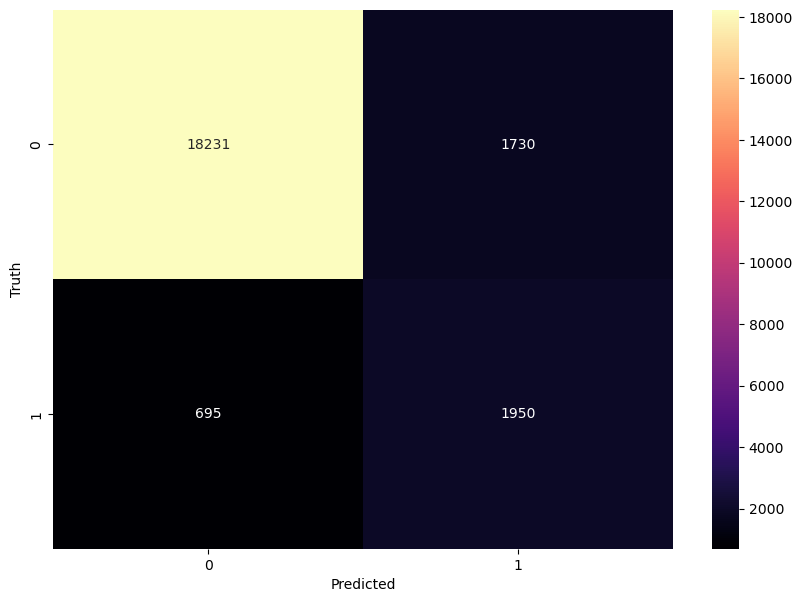

In [125]:
yhat_prob = loaded_model.predict(df_test.drop(["y_yes"], axis=1))
yhat_classes = (yhat_prob > 0.5).astype(int)  # threshold at 0.5

cm = tf.math.confusion_matrix(
    labels=df_test["y_yes"],
    predictions=yhat_classes
)

plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True, fmt='d', cmap='magma')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()